In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install torchensemble

     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import torchvision
from torchvision import transforms, models
from torchvision.models.segmentation import deeplabv3_resnet101

import torch
import torch.nn.functional as F
import torch.nn as nn   

import torchensemble

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import shutil

from tqdm import tqdm

import matplotlib.pyplot as plt
import time
import copy



In [111]:
torch.manual_seed(42)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


##Data preparation 

In [5]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [141]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(np.random.choice([224])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#    transforms.GaussianBlur([3,5]),
#    transforms.ColorJitter(hue = 0.5),
    transforms.Grayscale(3),
    transforms.RandomRotation(degrees=(0, 360)),
#    transforms.RandomAdjustSharpness(sharpness_factor=2),
#    transforms.RandomPerspective(),
#    transforms.RandomInvert(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#    transforms.CenterCrop(np.random.choice([224])),
#    transforms.RandomInvert(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [152]:
#Train data
#Used photographs preprocessed by a neural network - rembg (https://github.com/danielgatis/rembg)


data_train = '/content/drive/My Drive/Datasets/outtraining/train'

train_end_dataset = torchvision.datasets.ImageFolder(data_train, train_transforms)

batch_size = 40
train_end_dataloader = torch.utils.data.DataLoader(
    train_end_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

test_end_dataset = torchvision.datasets.ImageFolder(data_train, val_transforms)

batch_size = 40
test_end_dataloader = torch.utils.data.DataLoader(
    test_end_dataset, batch_size=batch_size, shuffle=False, num_workers=2)



In [153]:
#Test data

data_test = '/content/drive/My Drive/Datasets/outtraining/test'
    
test_dataset = ImageFolderWithPaths(data_test, val_transforms)


test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


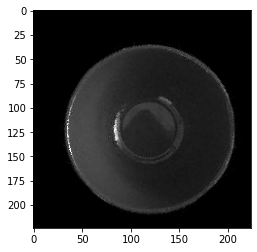

In [154]:
X_batch, y_batch = next(iter(train_end_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [41]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


##Train function

In [11]:
#Not used

def train_model(model, loss, optimizer, scheduler, num_epochs, data_tr, data_val, device):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = data_tr
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = data_val
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            epl = 0
            epcc = 0
            if phase == 'val':
                epl = epoch_loss
                epcc = epoch_acc.item()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return [model, epl, epcc]

##Mod-resnet

In [42]:
def modified_resnet():
    model = models.resnet152(pretrained=True)
    #model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))

    # Disable grad for all conv layers
    for param in model.parameters():
        param.requires_grad = False

    model.layer4.requires_grad = True

    model.avgpool = torch.nn.Sequential(
        torch.nn.Dropout(),
        torch.nn.AdaptiveAvgPool2d((1, 1))
    )


    model.fc =  torch.nn.Sequential(
#        torch.nn.Dropout(),
        torch.nn.Linear(model.fc.in_features, 2))
    return model

In [113]:
def modified_mobile():
    model = models.mobilenet_v2(pretrained = True)

    # Disable grad for all conv layers
    #for param in model.parameters():
    #param.requires_grad = False

    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
    #model.fc = torch.nn.Linear(model.fc.in_features, 2)
    return model

##Ensemble

In [155]:
#estim = modified_resnet()
estim = modified_mobile()

In [156]:
ensemble = torchensemble.voting.VotingClassifier(estimator = estim, n_estimators = 10)
ensemble.set_optimizer(
    "Adam",                                 # type of parameter optimizer
    lr=1.0e-3,                       # learning rate of parameter optimizer
#    weight_decay=weight_decay,              # weight decay of parameter optimizer
)

ensemble.set_scheduler(
    "StepLR",                    # type of learning rate scheduler
    step_size=7, 
    gamma=0.1,                           # additional arguments on the scheduler
)

##Work

In [157]:
ensemble.fit(
    train_loader = train_end_dataloader,
    epochs=20,                          # number of training epochs
    save_model = False
)

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 0.72047 | Correct: 23/40
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 0.73824 | Correct: 20/40
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 0.75707 | Correct: 21/40
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 0.68324 | Correct: 21/40
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 0.78222 | Correct: 21/40
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 0.73365 | Correct: 20/40
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 0.70726 | Correct: 20/40
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 0.74173 | Correct: 22/40
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 0.75615 | Correct: 22/40
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 0.74682 | Correct: 21/40
Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 0.24996 | Correct: 37/40
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 0.21847 | Correct: 38/40
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 0.26399 | Correct: 35/40
Estimator: 003 | Epoch: 001 | Batch: 0

##Prediction

In [158]:
test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = ensemble.predict(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


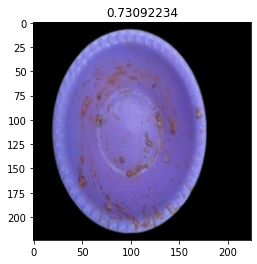

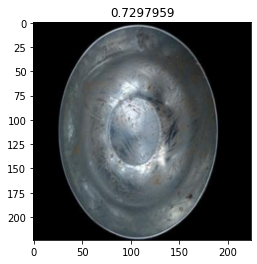

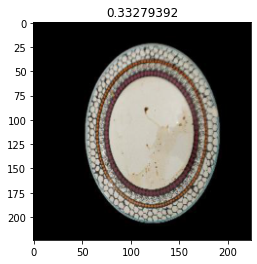

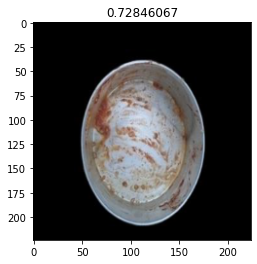

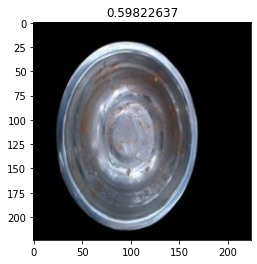

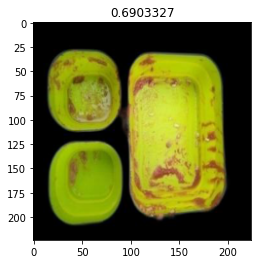

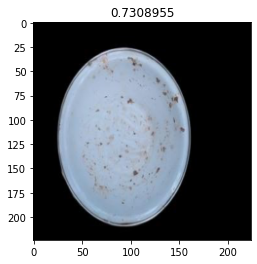

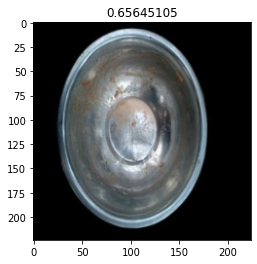

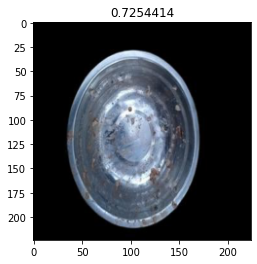

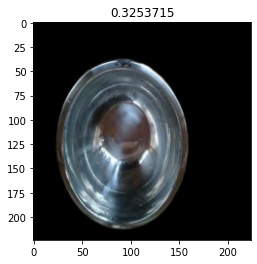

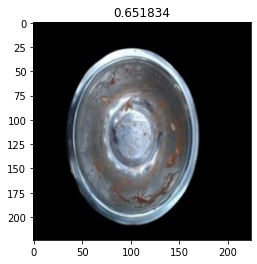

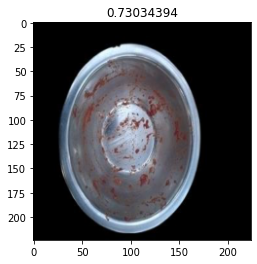

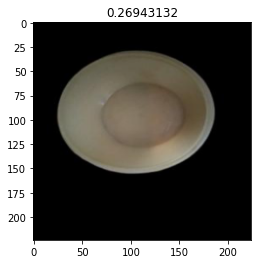

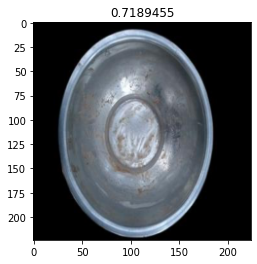

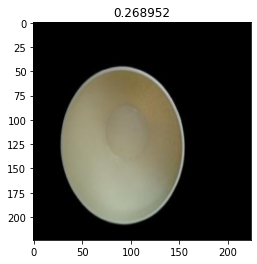

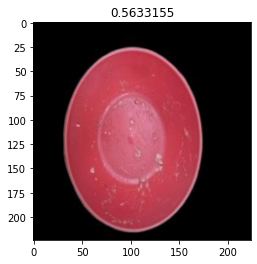

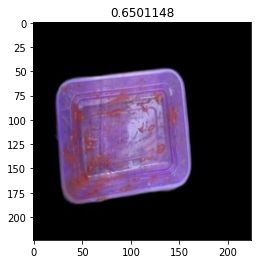

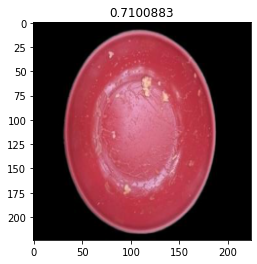

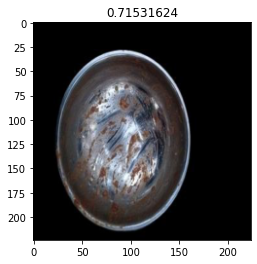

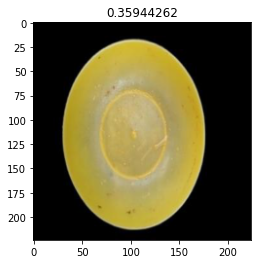

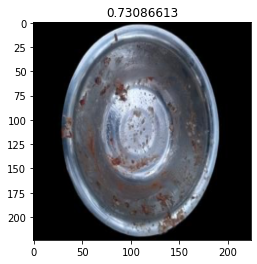

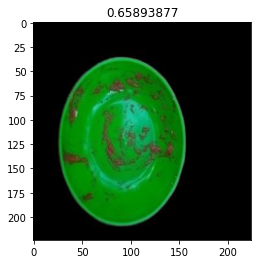

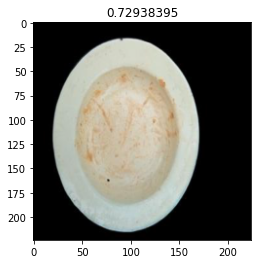

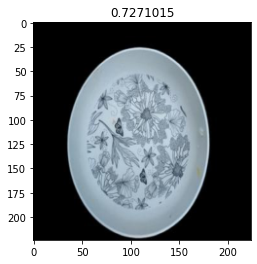

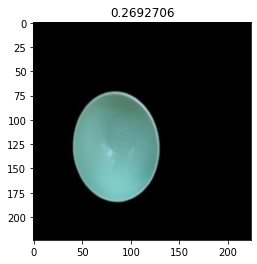

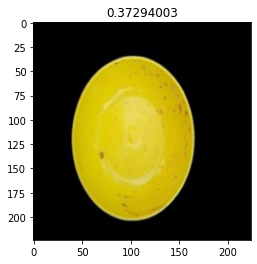

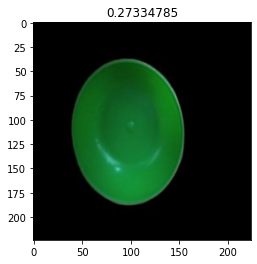

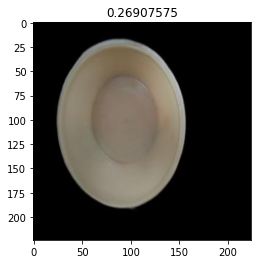

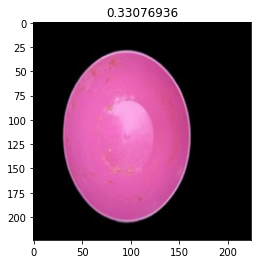

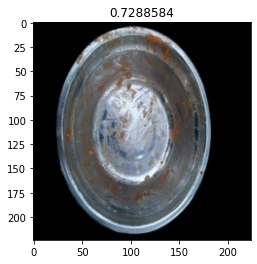

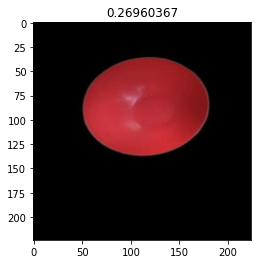

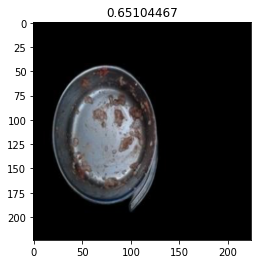

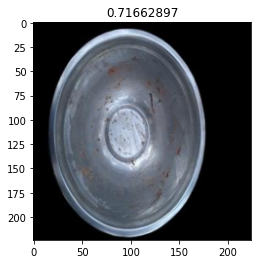

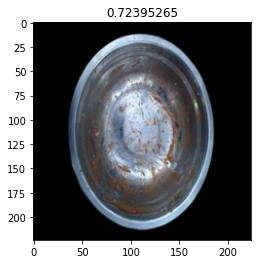

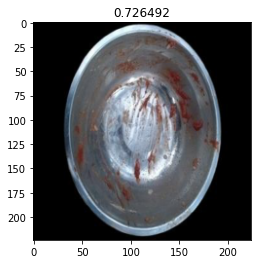

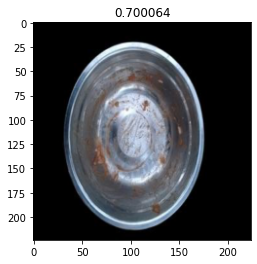

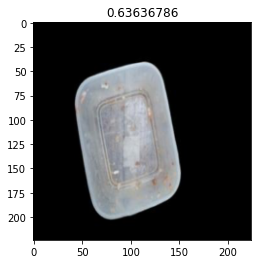

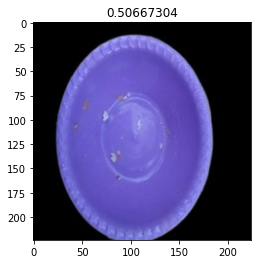

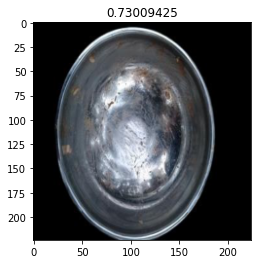

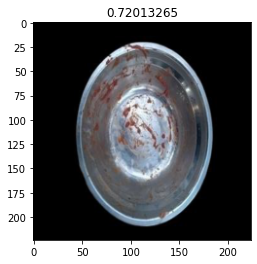

In [159]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [160]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [161]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/drive/My Drive/Datasets/outtraining/test/unclassed/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=10)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [162]:
submission_df.to_csv('submission.csv')